# Training, testing and evaluating models for the prediction of purchase of more than one quantity of a product based on city of the sales, state where the order is happening and Price of Product

In [2]:
import pandas as pd
import os
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_validate

In [3]:
# helper methods
def metrics_box_plot(model_name, accuracy_s, precision_s, recall_s, f1_s):
    print(model_name + "Accuracy: %0.2f (+/- %0.2f)" % (accuracy_scores.mean(), accuracy_scores.std() * 2))
    print(model_name + 'Average Accuracy Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(accuracy_scores.mean(),accuracy_scores.quantile(.05),accuracy_scores.quantile(.95),))
    print(model_name + "Precision: %0.2f (+/- %0.2f)" % (precision_scores.mean(), precision_scores.std() * 2))
    print(model_name + 'Average Precision Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(precision_scores.mean(),precision_scores.quantile(.05),precision_scores.quantile(.95),))
    print(model_name + "Recall: %0.2f (+/- %0.2f)" % (recall_scores.mean(), recall_scores.std() * 2))
    print(model_name + 'Average Recall Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(recall_scores.mean(),recall_scores.quantile(.05),recall_scores.quantile(.95),))
    print(model_name + "F1: %0.2f (+/- %0.2f)" % (f1_scores.mean(), f1_scores.std() * 2))
    print(model_name + 'Average F1 Score: {:.3} [5th percentile: {:.3} & 95th percentile:{:.3}]'
      .format(f1_scores.mean(),f1_scores.quantile(.05),f1_scores.quantile(.95),))
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))

    # Create a box plot for metrics a
    axs[0].boxplot(accuracy_s)
    axs[1].boxplot(precision_s)
    axs[2].boxplot(recall_s)
    axs[3].boxplot(f1_s)

    # Set the title and axis labels for each subplot
    axs[0].set_title('Distribution of classifier accuracy')
    axs[1].set_title('Distribution of classifier precision')
    axs[2].set_title('Distribution of classifier recall')
    axs[3].set_title('Distribution of classifier f1')
    axs[0].set_ylabel('Value')

    # Show the plot
    plt.show()

def plot_roc_curve(model_, x_train_resampled_, y_train_resampled_, x_test_, y_test_):
    # Calculate the false positive rate, true positive rate, and thresholds for the training data
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train_resampled_, model_.predict_proba(x_train_resampled_)[:, 1])
    auc_train = roc_auc_score(y_train_resampled_, model.predict_proba(x_train_resampled_)[:, 1])

    # Calculate the false positive rate, true positive rate, and thresholds for the testing data
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test_, model.predict_proba(x_test_)[:, 1])
    auc_test = roc_auc_score(y_test_, model.predict_proba(x_test_)[:, 1])

    # Plot the ROC curve and AUC score for the training data
    plt.plot(fpr_train, tpr_train, label='Training ROC curve (AUC = %0.2f)' % auc_train)

    # Plot the ROC curve and AUC score for the testing data
    plt.plot(fpr_test, tpr_test, label='Testing ROC curve (AUC = %0.2f)' % auc_test)

    # Add labels and title to the plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
df = pd.read_csv('./datasets/Sales_Data/Sales_April_2019.csv')
files = [file for file in os.listdir('./datasets/Sales_Data')]
all_months_data = pd.DataFrame()
for file in files:
    df = pd.read_csv('./datasets/Sales_Data/'+file)
    all_months_data = pd.concat([all_months_data, df], axis=0, ignore_index=True)

In [5]:
all_months_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


## Data Cleaning

In [6]:
## Check for Nan values
nan_df = all_months_data[all_months_data.isna().any(axis=1)]
nan_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
264,NaN,NaN,NaN,NaN,NaN,NaN
648,NaN,NaN,NaN,NaN,NaN,NaN
680,NaN,NaN,NaN,NaN,NaN,NaN
1385,NaN,NaN,NaN,NaN,NaN,NaN
1495,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
## Remove nan values
all_data = all_months_data.dropna(how='all')
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


In [8]:
nan_df = all_data[all_data.isna().any(axis=1)]
nan_df.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


In [9]:
# Checking Data Types
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186305 entries, 0 to 186848
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Order ID          186305 non-null  object
 1   Product           186305 non-null  object
 2   Quantity Ordered  186305 non-null  object
 3   Price Each        186305 non-null  object
 4   Order Date        186305 non-null  object
 5   Purchase Address  186305 non-null  object
dtypes: object(6)
memory usage: 9.9+ MB


In [10]:
# Invalid data format check and drop
initial_row_values = all_data.iloc[254].values
all_data = all_data.drop(all_data[all_data['Order ID'] == 'Order ID'].index)
row_values = all_data.iloc[254].values
print('Initial row values')
print(initial_row_values)
print('New row values')
print(row_values)

Initial row values
['Order ID' 'Product' 'Quantity Ordered' 'Price Each' 'Order Date'
 'Purchase Address']
New row values
['295902' 'AA Batteries (4-pack)' '2' '3.84' '12/26/19 21:54'
 '160 Maple St, Austin, TX 73301']


In [11]:
# Converting to appropriate data type
all_data['Quantity Ordered'] = pd.to_numeric(all_data['Quantity Ordered'])  # convert to int
all_data['Price Each'] = pd.to_numeric(all_data['Price Each'])  # convert to float

all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 0 to 186848
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Order ID          185950 non-null  object 
 1   Product           185950 non-null  object 
 2   Quantity Ordered  185950 non-null  int64  
 3   Price Each        185950 non-null  float64
 4   Order Date        185950 non-null  object 
 5   Purchase Address  185950 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.9+ MB


### Feature Engineering

In [12]:
# Engineering Sales Feature
all_data['One Quantity'] = all_data['Quantity Ordered'] == 1
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,One Quantity
0,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",True
1,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",True
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",True
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",True
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",True


In [13]:
# Engineering City and States
def get_city(address):
    return address.split(',')[1]

def get_state(address):
    return address.split(',')[2].split(' ')[1]

all_data['City'] = all_data['Purchase Address'].apply(lambda x: f"{get_city(x)}")
all_data['State'] = all_data['Purchase Address'].apply(lambda x: f"{get_state(x)}")
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,One Quantity,City,State
0,295665,Macbook Pro Laptop,1,1700.00,12/30/19 00:01,"136 Church St, New York City, NY 10001",True,New York City,NY
1,295666,LG Washing Machine,1,600.00,12/29/19 07:03,"562 2nd St, New York City, NY 10001",True,New York City,NY
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001",True,New York City,NY
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016",True,San Francisco,CA
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301",True,Atlanta,GA


### Manually dropping of columns not needed for analysis

In [14]:
all_data.drop(['Order ID', 'Order Date', 'Purchase Address', 'Product', 'Quantity Ordered'], axis=1, inplace=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 185950 entries, 0 to 186848
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Price Each    185950 non-null  float64
 1   One Quantity  185950 non-null  bool   
 2   City          185950 non-null  object 
 3   State         185950 non-null  object 
dtypes: bool(1), float64(1), object(2)
memory usage: 5.9+ MB


In [15]:
all_data.head()

,Price Each,One Quantity,City,State
0,1700.00,True,New York City,NY
1,600.00,True,New York City,NY
2,11.95,True,New York City,NY
3,149.99,True,San Francisco,CA
4,11.95,True,Atlanta,GA


### Features Analysis

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


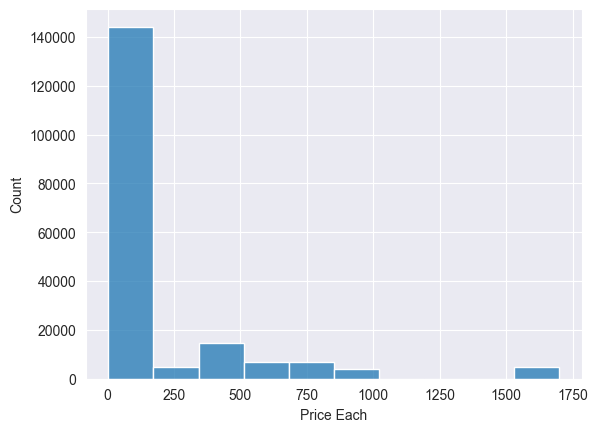

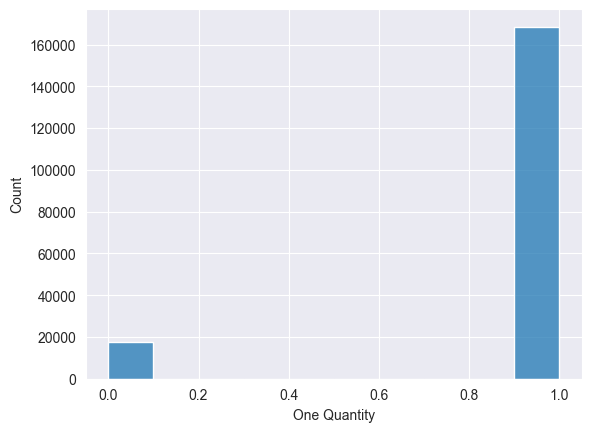

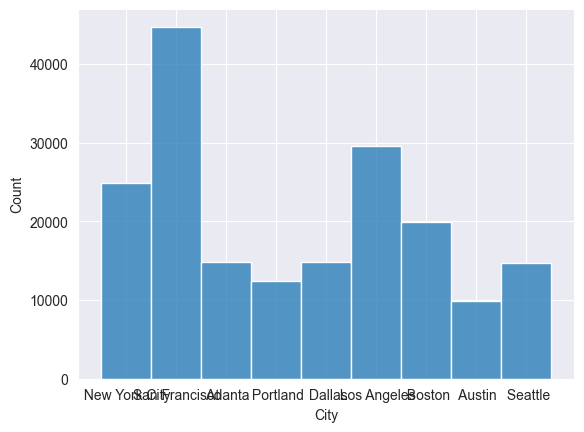

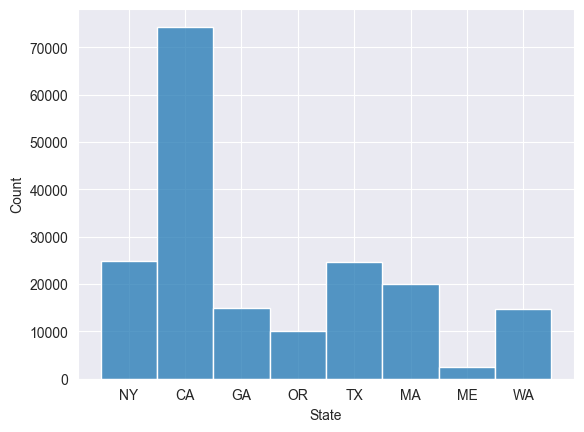

In [16]:
for i, col in enumerate(all_data.columns):
  plt.figure(i)
  plt
  sns.histplot(x = col, data = all_data, bins =10)

plt.show()

### Label encoding

In [17]:
### Encoding label to allow checking for correlation between more input features and also to prepare for model training
le = LabelEncoder()
all_data['State'] = le.fit_transform(all_data['State'])
all_data['City'] = le.fit_transform(all_data['City'])
all_data['One Quantity'] = le.fit_transform(all_data['One Quantity'])

### Checking for correlation of input features

In [18]:
corr = all_data.corr()
corr

,Price Each,One Quantity,City,State
Price Each,1.000000,0.168092,-0.000096,0.002176
One Quantity,0.168092,1.000000,0.000482,-0.003471
City,-0.000096,0.000482,1.000000,-0.022792
State,0.002176,-0.003471,-0.022792,1.000000


### Visualising correlation using seaborn heatmap

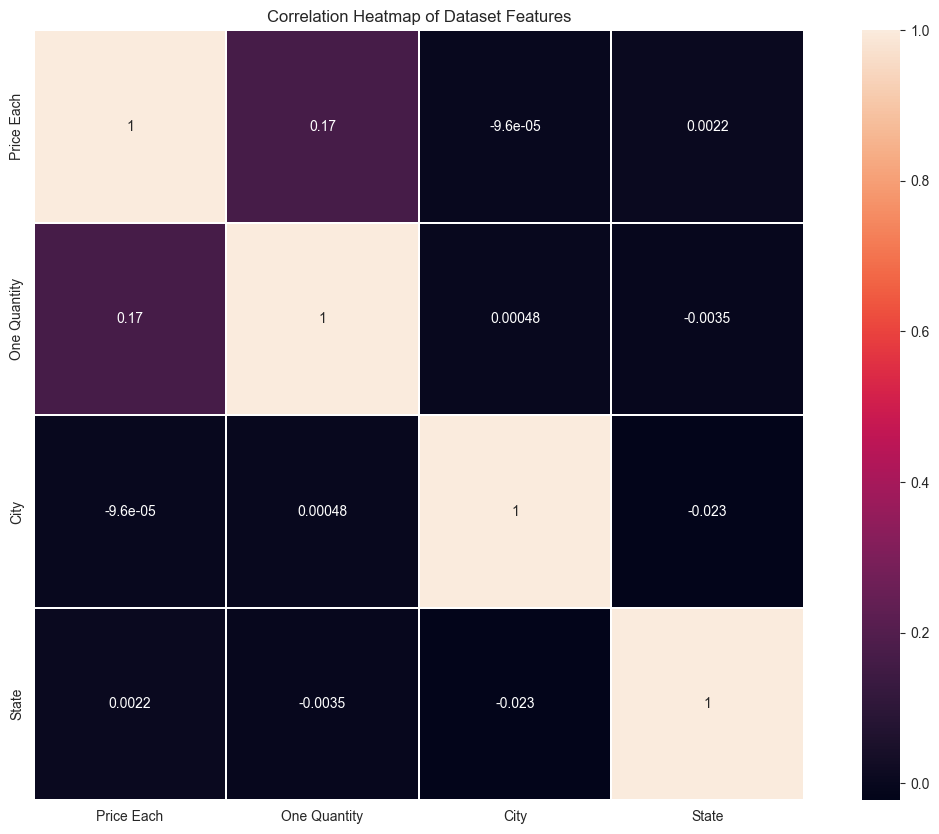

In [19]:
#heat map plot
plt.gcf().set_size_inches((15,10))
sns.heatmap(corr,
        xticklabels=corr.columns,
        yticklabels=corr.columns,
            square=True, linewidths=0.15, annot=True)
plt.title('Correlation Heatmap of Dataset Features')
plt.show()

### Splitting dataset into training & testing set for Quantity ordered prediction

In [20]:
x = all_data.drop('One Quantity', axis=1)
y = all_data['One Quantity']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (148760, 3)
y_train shape: (148760,)
x_test shape: (37190, 3)
y_test shape: (37190,)


In [21]:
# Check for class balance
y_train.value_counts()

1    134803
0     13957
Name: One Quantity, dtype: int64

<AxesSubplot: xlabel='One Quantity', ylabel='count'>

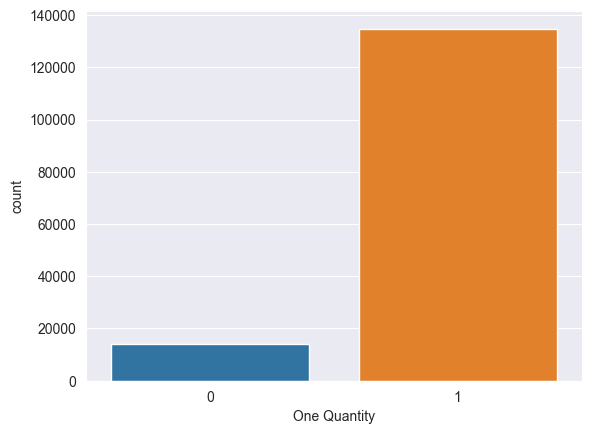

In [22]:
sns.countplot(x=y_train)

In [23]:
smote = SMOTE()
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)
y_train_resampled.value_counts()

0    134803
1    134803
Name: One Quantity, dtype: int64

<AxesSubplot: xlabel='One Quantity', ylabel='count'>

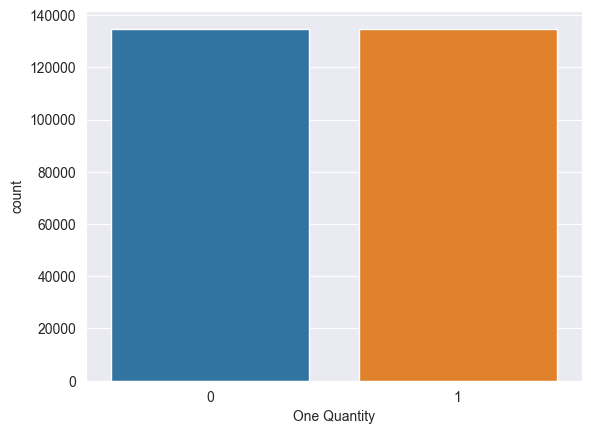

In [24]:
sns.countplot(x=y_train_resampled)

Naive BayesAccuracy: 0.73 (+/- 0.00)
Naive BayesAverage Accuracy Score: 0.733 [5th percentile: 0.731 & 95th percentile:0.734]
Naive BayesPrecision: 0.96 (+/- 0.00)
Naive BayesAverage Precision Score: 0.958 [5th percentile: 0.957 & 95th percentile:0.96]
Naive BayesRecall: 0.49 (+/- 0.01)
Naive BayesAverage Recall Score: 0.486 [5th percentile: 0.483 & 95th percentile:0.491]
Naive BayesF1: 0.64 (+/- 0.01)
Naive BayesAverage F1 Score: 0.642 [5th percentile: 0.632 & 95th percentile:0.648]


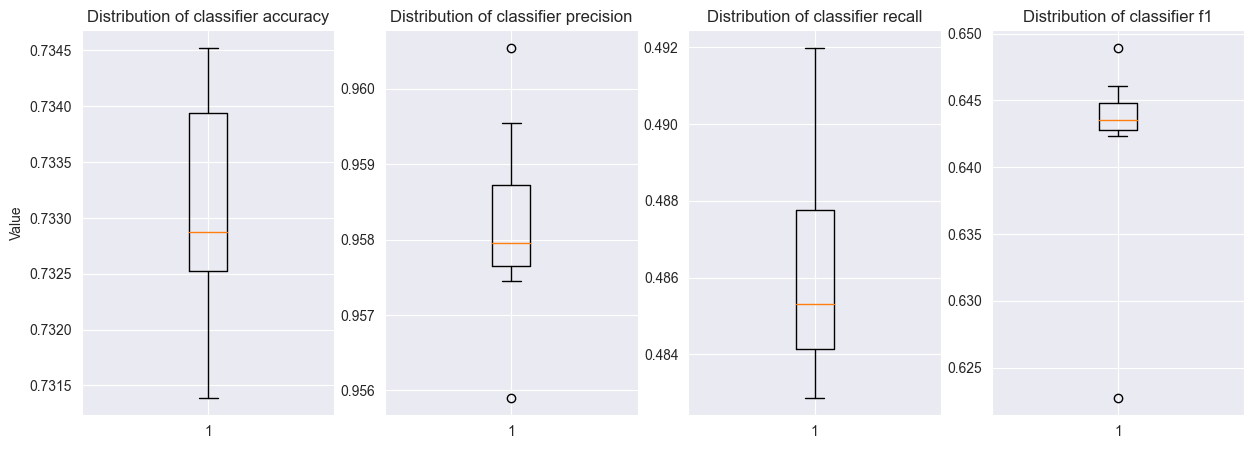

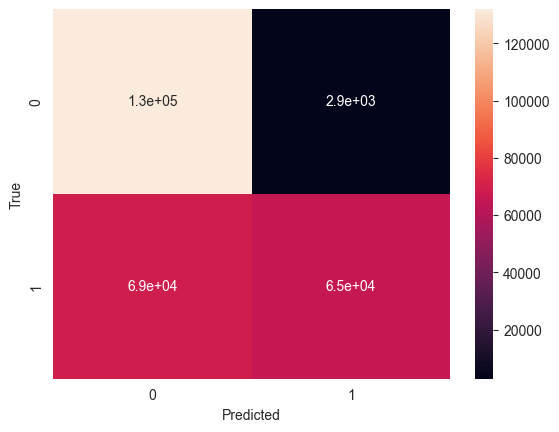

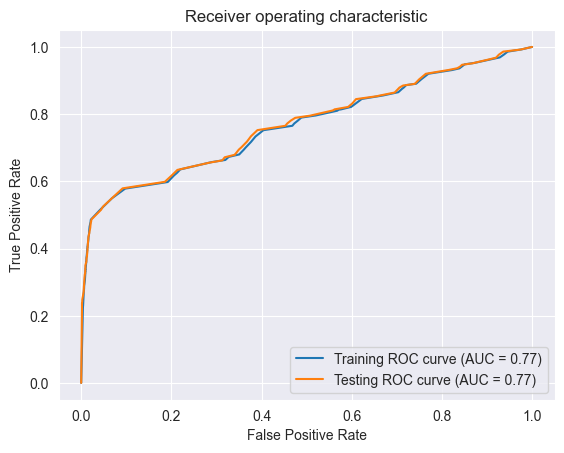

Decision TreeAccuracy: 0.76 (+/- 0.00)
Decision TreeAverage Accuracy Score: 0.762 [5th percentile: 0.759 & 95th percentile:0.765]
Decision TreePrecision: 0.76 (+/- 0.00)
Decision TreeAverage Precision Score: 0.757 [5th percentile: 0.754 & 95th percentile:0.76]
Decision TreeRecall: 0.77 (+/- 0.01)
Decision TreeAverage Recall Score: 0.771 [5th percentile: 0.762 & 95th percentile:0.779]
Decision TreeF1: 0.77 (+/- 0.00)
Decision TreeAverage F1 Score: 0.766 [5th percentile: 0.763 & 95th percentile:0.769]


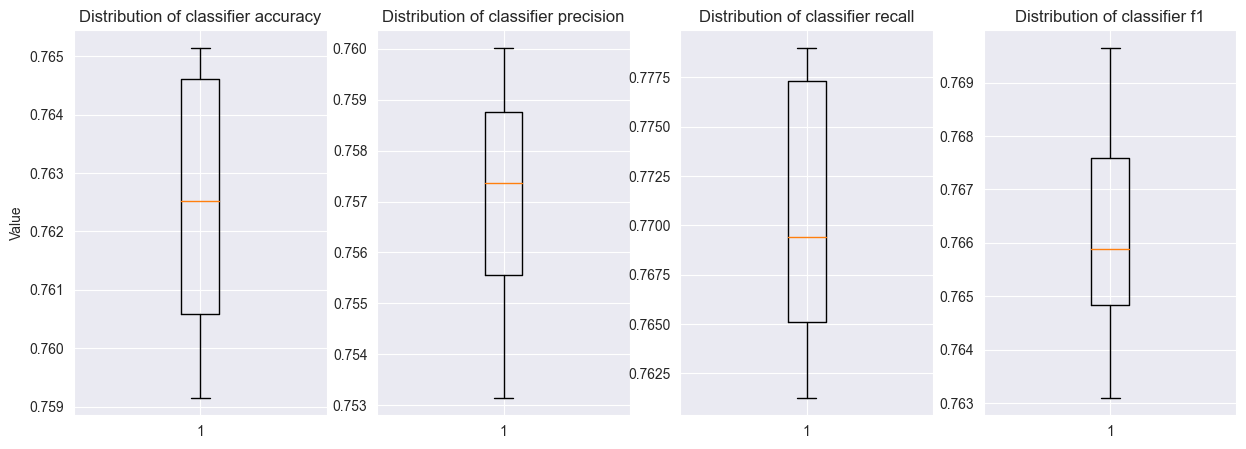

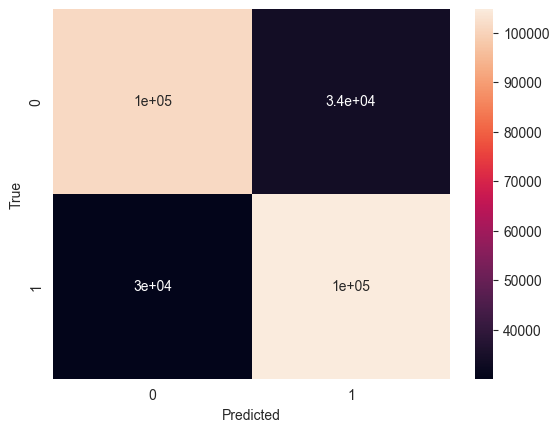

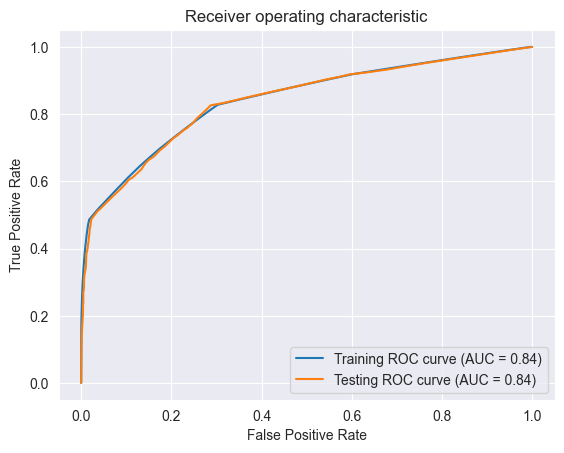

In [ ]:
## Models to evaluate
models = {
    'Naive Bayes':  GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boost ': GradientBoostingClassifier(),
}

for name, model in models.items():
    # Cross validation
    rs = ShuffleSplit(n_splits=10, test_size=0.2)

    accuracy_scorer = make_scorer(accuracy_score)
    precision_scorer = make_scorer(precision_score, zero_division=0)
    recall_scorer = make_scorer(recall_score)
    f1_scorer = make_scorer(f1_score)

    accuracy_results = cross_validate(model, x_train_resampled, y_train_resampled, cv=rs, scoring=accuracy_scorer, return_train_score=False)
    precision_results = cross_validate(model, x_train_resampled, y_train_resampled, cv=rs, scoring=precision_scorer)
    recall_results = cross_validate(model, x_train_resampled, y_train_resampled, cv=rs, scoring=recall_scorer)
    f1_results = cross_validate(model, x_train_resampled, y_train_resampled, cv=rs, scoring=f1_scorer)

    model.fit(x_train_resampled, y_train_resampled)
    y_pred = model.predict(x_train_resampled)

    accuracy_scores = pd.Series(accuracy_results['test_score'])
    precision_scores = pd.Series(precision_results['test_score'])
    recall_scores = pd.Series(recall_results['test_score'])
    f1_scores = pd.Series(f1_results['test_score'])

    result = {
        'name' : name,
        'accuracy_scores': accuracy_scores,
        'precision_scores': precision_scores,
        'recall_scores': recall_scores,
        'f1_scores': f1_scores,
    }

    metrics_box_plot(name, accuracy_scores, precision_scores, recall_scores, f1_scores)

    # Plotting confusion matrix for true positive and predicted
    cm = confusion_matrix(y_train_resampled, y_pred)
    sns.heatmap(cm, annot=True)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    #plot roc
    plot_roc_curve(model, x_train_resampled, y_train_resampled, x_test, y_test)